In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import src.io as sio
import src.qudi_fit_wrapper as qft
import src.helpers as shp
import src.fitting as sft

plt.style.use('seaborn')

In [3]:
DATA_FOLDER = "20220505_FR0612-F2-3B6_uhv"
DATA_FOLDERPATH, FIGURE_FOLDERPATH = sio.get_data_and_figure_paths(DATA_FOLDER)

src.io :: INFO :: qudiamond folderpath is \\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv\


In [ ]:
t1 = sio.read_pulsed_measurement_dataclass(DATA_FOLDERPATH, measurement_str="t1")

In [ ]:
keys_to_plot = ['20220515-2324-45', '20220516-0954-27']

In [ ]:
keys_to_plot = dict(list(t1.items())[-2:])

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(nrows=len(keys_to_plot), sharex=True, figsize=(6, 6))

for idx, t1_meas in enumerate(keys_to_plot.values()):
    df_data =  t1_meas.pulsed_measurement.get_data()
    x = df_data["Controlled variable(s)"] * 1e3

    # y, yerr = qft.analyse_mean_norm(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9, norm_start=2000e-9, norm_end=3000e-9)
    y, yerr = qft.analyse_mean(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9)
    # y, yerr = qft.analyse_mean_reference(t1_meas.laser_pulses.get_data(), signal_start=170e-9, signal_end=250e-9, norm_start=2000e-9, norm_end=3000e-9)
    # y /= np.max(y)

    ax[idx].errorbar(x, y, yerr=yerr, fmt="o")

    fit_x, fit_y, result = qft.perform_fit(x, y, "decayexponentialstretched")
    print(result.fit_report())
    # ax[idx].set_title(f"T1 = {round(result.params['lifetime'].value)} ms")
    ax[idx].plot(fit_x, fit_y)
    
    
ax[-1].set_xlabel("Time (ms)")
fig.tight_layout()

# sio.save_figures("t1_comparison", FIGURE_FOLDERPATH)

In [4]:
autocorr_paths, autocorr_files = sio.get_measurement_file_list(DATA_FOLDERPATH, "Autocorrelation")

\\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv\2022\05\20220517\Confocal: : 42it [00:03, 13.34it/s]         


In [5]:
main_pressures = np.array([1.78, 2.32, 2.89, 3.51, 4.2, 5.04, 5.98, 7.11, 8.27, 9.6]) * 1e-6

src.io :: INFO :: Saving 'autocorr_comparison_pressure' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'


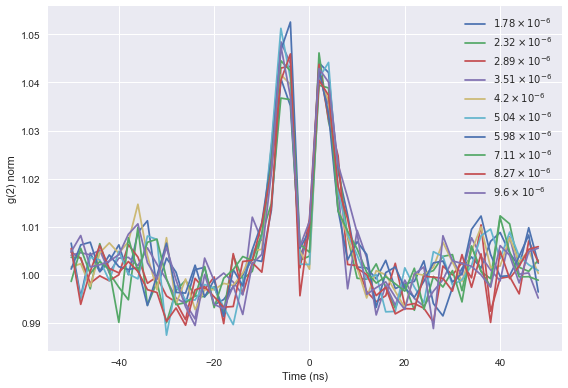

In [7]:
fig, ax = plt.subplots()

idx = 0
for auto_path, auto_file in zip(autocorr_paths, autocorr_files):
    if "idx" in auto_path:
        df = sio.read_into_df(auto_path)
        
        x = df["Time (ps)"] / 1e3
        y = df["g2(t) norm"]
        ax.plot(x, y, label=shp.format_exponent_as_str(main_pressures[idx]))
        
        idx += 1 
        
ax.legend()

ax.set_ylabel("g(2) norm")
ax.set_xlabel("Time (ns)")

fig.tight_layout()
sio.save_figures("autocorr_comparison_pressure", FIGURE_FOLDERPATH)

In [8]:
confocal_paths, confocal_files = sio.get_measurement_file_list(DATA_FOLDERPATH, "Confocal")

\\kernix\qudiamond\Data\20220505_FR0612-F2-3B6_uhv\2022\05\20220517\Confocal: : 42it [00:03, 12.89it/s]         


C:\Users\pinto\AppData\Local\Temp\ipykernel_20040\615762409.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(img, cax=cbar_ax)
src.io :: INFO :: Saving 'confocal_comparison_pressure' to 'C:/Nextcloud\Data_Analysis\20220505_FR0612-F2-3B6_uhv'


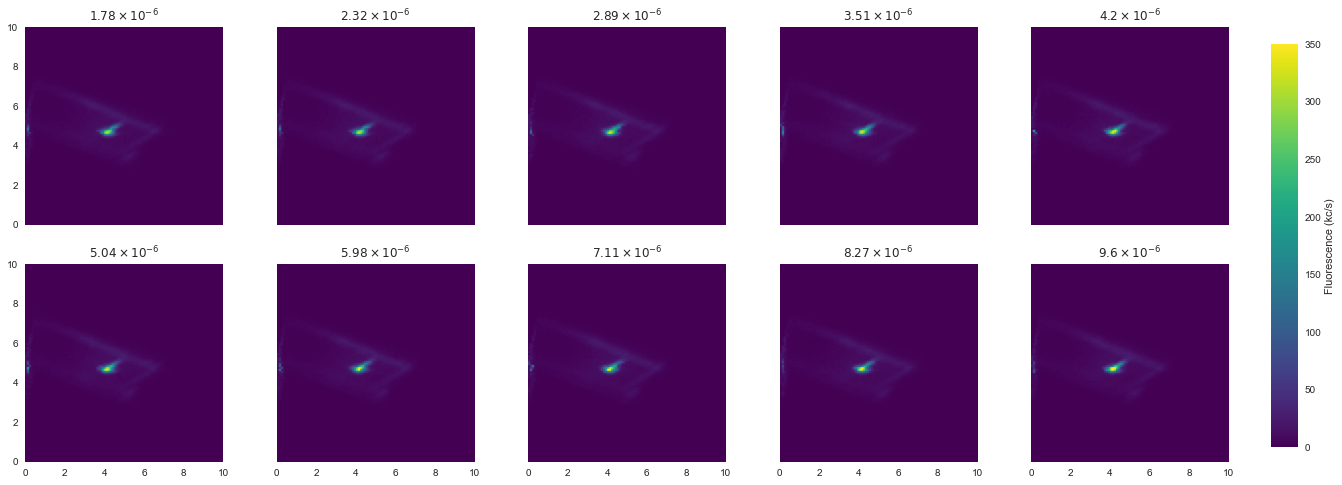

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 8), sharex=True, sharey=True)

i, j = 1, 4
idx = 9
for path, name in zip(confocal_paths, confocal_files):
    if "idx" in path and "image" in path:
        params = sio.read_qudi_parameters(path)
        data = np.genfromtxt(path, dtype=None, delimiter='\t')
        extent = np.array([params['X image min (m)'], params['X image max (m)'], params['Y image min'], params['Y image max']]) * 1e3
        img = ax[i, j].imshow(data/1e3, cmap="viridis", origin="lower", extent=extent, vmin=0, vmax=350)
        ax[i, j].grid(False)
        ax[i, j].set_title(shp.format_exponent_as_str(main_pressures[idx]))
        
        j -= 1
        if j < 0:
            i -= 1
            j = 4
        idx -= 1
            
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
cbar = fig.colorbar(img, cax=cbar_ax)
cbar.set_label("Fluorescence (kc/s)")

sio.save_figures("confocal_comparison_pressure", FIGURE_FOLDERPATH)